# Data Exploration

In [1]:
import pandas as pd
import numpy as np

In [2]:
df_full = pd.read_excel('cordata.xlsx') # contains all data
df_Al = pd.read_excel('cordata_Al.xlsx') # only Al alloy class

FileNotFoundError: [Errno 2] No such file or directory: 'cordata.xlsx'

In [3]:
print(df_full.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4973 entries, 0 to 4972
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Index                   4973 non-null   int64  
 1   Inhibitor               4973 non-null   object 
 2   Mol._weight             4973 non-null   float64
 3   SMILES                  4973 non-null   object 
 4   Metal                   4973 non-null   object 
 5   Alloy                   4973 non-null   object 
 6   Time_h                  4973 non-null   float64
 7   Temperature_K           4973 non-null   float64
 8   pH                      4973 non-null   float64
 9   Inhib_Concentrat_M      4973 non-null   float64
 10  Salt_Concentrat_M       4973 non-null   float64
 11  Synergistic_Inhib_type  265 non-null    object 
 12  Synergistic_Inhib_M     4925 non-null   float64
 13  Methodology             4973 non-null   object 
 14  Reference               4973 non-null   

In [4]:
print(df_Al.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2011 entries, 0 to 2010
Data columns (total 19 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Inhibitor                       2011 non-null   object 
 1   SMILES                          2011 non-null   object 
 2   Number                          2011 non-null   int64  
 3   Metal                           2011 non-null   object 
 4   Alloy                           2011 non-null   object 
 5   Time_h                          2011 non-null   float64
 6   Temperature_K                   2011 non-null   int64  
 7   pH                              2011 non-null   float64
 8   Inhib_Concentrat_M              2011 non-null   float64
 9   Salt_Concentrat_M               2011 non-null   float64
 10  Synergistic_inhib               2011 non-null   object 
 11  Synergistic_inhib_type          2011 non-null   object 
 12  Synergistic_inhib_Concentrat_M  20

In [5]:
# number of entries for every alloy class in the full dataset
for metal in df_full['Metal'].unique():
    print(f"{metal}: {len(df_full[df_full['Metal'] == metal])}")

Al: 2001
Cu: 272
Fe: 1230
Mg: 1465
Zn: 5


### since Al has the biggest number it is indeed smart to start the alloy specific analysis with Al

In [6]:
# unique compounds for full dataset
df_full.groupby('SMILES').agg({'Efficiency':['median', 'std']})

Efficiency            
                                                       median         std
SMILES                                                                   
Brc1ncccn1                                               13.9    6.407808
C(=O)(C(=O)[O-])[O-]                                     33.0   66.649155
C(C(=O)O)(C)(CO)CO                                       63.5   14.066509
C(C(=O)O)N                                             -289.0         NaN
C(C(=O)[O-])C(CC(=O)[O-])(C(=O)[O-])O                    63.6  171.524937
...                                                       ...         ...
c1ncn[nH]1                                              -16.5  376.741314
c2ccc1[nH]cnc1c2                                         47.9   10.392243
c3ccc(Cn2cnc1ccccc12)cc3                                 97.5    0.223607
c4ccc(Cn3c(c1ccccc1)nc2ccccc23)cc4                       97.8    0.316228
n1c2C(=O)NC(N)=Nc2ncc1CNc3ccc(cc3)C(=O)N[C@H](C...       82.4   20.836281

[402 rows x 2 columns]

In [7]:
# unique compounds for Al only dataset
df_Al.groupby('SMILES').agg({'Efficiency':['median', 'std']})

Efficiency           
                                                       median        std
SMILES                                                                  
C(=O)(C(=O)[O-])[O-]                                   20.000  15.146012
C(C(=O)[O-])C(CC(=O)[O-])(C(=O)[O-])O                  71.300  33.074888
C(C(C(C(C(C(=O)[O-])O)O)O)O)O.C(C(C(C(C(C(=O)[O...     65.000  22.500907
C(C(C(C(C(C(=O)[O-])O)O)O)O)O.C(C(C(C(C(C(=O)[O...     61.000  32.650756
C(C(CO)([N+](=O)[O-])Br)O                              84.285   9.737557
...                                                       ...        ...
[O-]S(=O)[O-].[Na+].[Na+]                              85.200  15.171265
c1cc(ccc1c2[nH]c(nn2)S)[N+](=O)[O-]                    25.000   5.773503
c1ccc(nc1)c1ccccn1                                     30.000   8.164966
c1ccc2c(c1)[nH]nn2                                     91.000  31.045126
c1ncn[nH]1                                             35.000  34.034296

[177 rows x 2 columns]

### 402 compounds for full, 177 for only Al. How about if we work for the largest alloy group?

In [14]:
def value_counts(df, value):
    # Count unique values in the 'value' column
    value_counts = df[value].value_counts()
    ranked_values = value_counts.sort_values(ascending=False)
    print("Rank of unique values:")
    print(ranked_values)

value_counts(df_full, 'Alloy')
print()
print(f'Unique alloys in full dataset: {len(df_full["Alloy"].unique())}')
print(f'Unique alloys in only Al dataset: {len(df_Al["Alloy"].unique())}')

Rank of unique values:
Mild steel           690
AA2024               590
Al                   424
Cu                   262
CP-Mg-220ppm         239
AA7075               227
AA1060               203
Cold rolled steel    182
AZ31                 158
AlSi                 155
ZE41                 155
WE43                 153
AM50                 153
AZ91                 145
Fe                   143
E21                  133
HP-Mg-50ppm          119
HP-Mg-51ppm          109
Carbon steel          92
AA5754                84
Steel                 75
CP-Mg-342ppm          60
Al_rod                49
Stainless steel       48
AA6063                48
AA6061                48
AA5083                46
AA5052                45
Mg-0,8Ca              25
AA1100                25
AA3SR                 18
AZ91E                 15
AA63400               12
AA2014                12
Brass                 10
AA5005                 8
AA2017A                7
Galvanized             5
AZ91D                  1
Na

### I suggest we start from AA2024, as mild steel is too general of a category.

In [21]:
# composition of AA2000 series is nearly identical, grab alloys from this series
df_AA2024 = df_Al[df_Al['Alloy'].isin(['AA2024', 'AA2014', 'AA2017A'])]
df_AA2024.groupby('SMILES').agg({'Efficiency':['median', 'std']})

Efficiency           
                                                       median        std
SMILES                                                                  
C(=O)(C(=O)[O-])[O-]                                    20.00  14.061383
C(C(=O)[O-])C(CC(=O)[O-])(C(=O)[O-])O                   12.55  40.887682
C(C(C(C(C(C(=O)[O-])O)O)O)O)O.C(C(C(C(C(C(=O)[O...      65.00  22.500907
C(C(C(C(C(C(=O)[O-])O)O)O)O)O.C(C(C(C(C(C(=O)[O...      61.00  32.650756
C1=CC(=C(C=C1O)O)C=NNC(=S)N                             86.60  26.204889
...                                                       ...        ...
[O-]S(=O)[O-].[Na+].[Na+]                               85.20  15.171265
c1cc(ccc1c2[nH]c(nn2)S)[N+](=O)[O-]                     25.00   7.071068
c1ccc(nc1)c1ccccn1                                      35.00   7.071068
c1ccc2c(c1)[nH]nn2                                      97.80  20.848309
c1ncn[nH]1                                              60.00  42.426407

[123 rows x 2 columns]

### 177 compounds for all Al, to 123 compounds to only AA2024.

In [22]:
# you can play around with the column names to see what unique values are in each column
column_name = 'Time_h'
print(df_Al[column_name].unique())
print((len(df_Al[column_name].unique())))

[2.40e+01 6.72e+02 0.00e+00 1.67e+00 3.30e-01 5.80e-01 1.00e+00 5.00e-01
 1.50e+00 2.00e+00 2.50e+00 4.80e+01 9.60e+01 1.44e+02 1.92e+02 2.40e+02
 2.88e+02 3.36e+02 3.84e+02 4.00e+00 6.00e+00 8.00e+00 2.50e-01 7.50e-01
 7.20e+01 3.60e+02 4.80e+02 6.00e+02 1.68e+02 1.20e+02 1.00e+01 3.00e+00
 4.32e+02 5.28e+02 5.76e+02 6.24e+02 3.50e+00 4.50e+00 5.00e+00 5.50e+00
 7.20e+02 6.70e-01]
42


In [30]:
# previous counter fuinction to check distribution
value_counts(df_Al, 'Time_h')

Rank of unique values:
24.00     656
0.50      306
2.00      268
1.00      134
672.00     54
3.00       48
144.00     48
48.00      47
72.00      41
1.67       40
168.00     28
0.33       28
240.00     25
96.00      22
336.00     20
4.00       19
288.00     19
6.00       17
480.00     16
0.67       16
0.00       14
192.00     14
384.00     14
576.00     13
432.00     13
10.00       9
360.00      8
120.00      8
528.00      8
624.00      8
600.00      7
0.58        7
2.50        6
1.50        6
720.00      5
5.00        4
8.00        4
4.50        3
3.50        3
5.50        3
0.25        1
0.75        1
Name: Time_h, dtype: int64


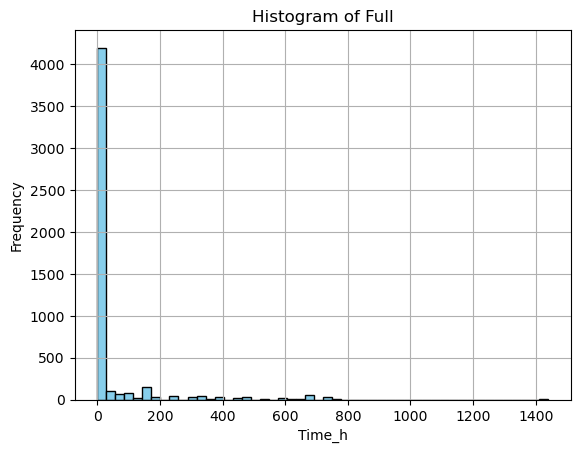

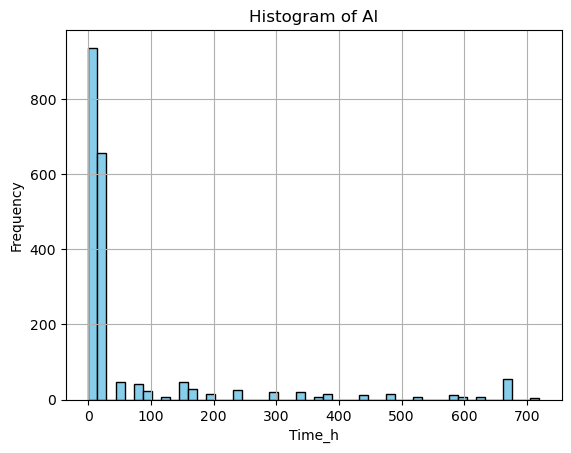

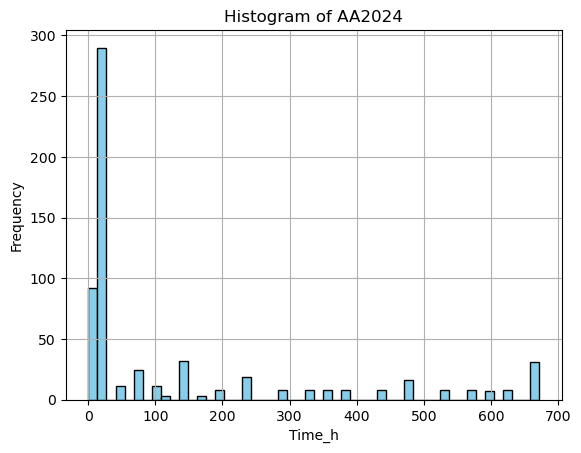

In [26]:
# you can play around with histograms below to check distribution
# 
# # Plot histogram
import matplotlib.pyplot as plt

def plot_hist(df, value, name):
    plt.hist(df[value], bins=50, color='skyblue', edgecolor='black')
    plt.xlabel(f'{value}')
    plt.ylabel('Frequency')
    plt.title(f'Histogram of {name}')
    plt.grid(True)
    plt.show()

hist_value = 'Time_h'
plot_hist(df_full, value = hist_value, name = 'Full')
plot_hist(df_Al, value = hist_value, name = 'Al')
plot_hist(df_AA2024, value = hist_value, name = 'AA2024')

In [41]:
# check filtering to see the effect of getting rid of some rows, to check whether its feasible to drop some columns

def check_filter(dataset, column_name, filter):
    print(f"Number of entries in full dataset: {len(dataset)}")
    print(f"Number of entries in full dataset with {column_name} >= {filter}: {len(dataset[dataset[column_name] >= filter])}")
    print(f"Number of entries in full dataset with {column_name} < {filter}: {len(dataset[dataset[column_name] < filter])}")


check_filter(dataset = df_Al, column_name = 'Time_h',  filter = 1)



Number of entries in full dataset: 2011
Number of entries in full dataset with Time_h >= 1: 1638
Number of entries in full dataset with Time_h < 1: 373


In [55]:
# quick check to check the amount of unique compounds
filtered_df_Al = df_AA2024[df_AA2024['Time_h'] >= 1] # 123 to 121 compounds, maybe not much information loss for the small dataset...
len(filtered_df_Al['SMILES'].unique())

121

### Now to create a new dataframe cleaned of unnecessary details for analysis. 
Entries with synergy and encapsulation is removed, then unnecessary columns dropped.

In [65]:
def filter_dataframe_AA2024(df):
    no_synergy_df = df[df['Synergistic_inhib'] == 'No']
    no_encapsulation_df = no_synergy_df[no_synergy_df['Encapsulated'] == 'No']
    filtered_df = no_encapsulation_df.drop(columns=['Inhibitor', 'Number', 'Metal', 'Alloy', 'Temperature_K', 'Salt_Concentrat_M', 
                                                    'Synergistic_inhib','Synergistic_inhib_type', 'Synergistic_inhib_Concentrat_M',
                                                    'Encapsulated', 'Methodology','Reference', 'Link', 'Contributor'])
    return filtered_df

filtered_df_AA2024 = filter_dataframe_AA2024(df_AA2024)
len(filtered_df_AA2024['SMILES'])


611

### 611 datapoints for actual Bayesian optimization work. 

In [92]:
# save
filtered_df_AA2024.to_excel('filtered_AA2024.xlsx', index=False)

In [93]:
def filter_dataframe_Al(df):
    no_synergy_df = df[df['Synergistic_inhib'] == 'No']
    no_encapsulation_df = no_synergy_df[no_synergy_df['Encapsulated'] == 'No']
    filtered_df = no_encapsulation_df.drop(columns=['Inhibitor', 'Number', 'Metal', 'Temperature_K', 'Salt_Concentrat_M', 
                                                    'Synergistic_inhib','Synergistic_inhib_type', 'Synergistic_inhib_Concentrat_M',
                                                    'Encapsulated', 'Methodology','Reference', 'Link', 'Contributor'])
    return filtered_df

filtered_df_Al = filter_dataframe_Al(df_Al)
len(filtered_df_Al['SMILES'])

1966

### 1966 datapoints, almost 3 times. Assuming we can just ignore the effect of alloy type, or find a way to featurize it, would be fun to work with. Maybe composition based?

In [94]:
# save
filtered_df_Al.to_excel('filtered_Al.xlsx', index=False)

In [89]:
def filter_dataframe_full(df):
    no_synergy_df = df[df['Synergistic_Inhib_type'].isnull()]
    filtered_df = no_synergy_df.drop(columns=['Inhibitor', 'Index', 'Mol._weight', 'Temperature_K', 'Salt_Concentrat_M',
                                              'Synergistic_Inhib_type', 'Synergistic_Inhib_M','Methodology','Reference',
                                              'Contributor'])
    return filtered_df

filtered_df_full = filter_dataframe_full(df_full)
len(filtered_df_full['SMILES'])

4708

### 4708 datapoints, we more than double the previous. Again if we can jump to the featurization of alloy or substrate, super cool number to work with.

In [91]:
# save
filtered_df_full.to_excel('filtered_full.xlsx', index=False)